In [1]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np

In [2]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    # import data
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [18]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

# 2016-2019 data
df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 25000)& (df1['usd_pledged'] > 2500)]
df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')


/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
### CREATORS WITH MULTIPLE CROWDFUNDING CAMPAIGNS

df2 = df1.copy()

# creators that have started more than one Kickstarter project
df2 = df2.loc[df2['creator_id'].isin(df2['creator_id'].value_counts()[df2['creator_id'].value_counts()>=2].index)]
# first sort by creator id, then sort by date
df2.sort_values(['creator_id', 'deadline'], ascending = [True, True], inplace = True)

creator_freq = df2['creator_id'].value_counts().to_dict()
print('Average number of rounds for creators with >1 project')
print(sum(creator_freq.values()) / len(creator_freq.values()))
df2_success_first = pd.DataFrame() # success first
df2_fail_first = pd.DataFrame() # fail first
for l in creator_freq:
    temp = df2.loc[df2['creator_id'] == l]
    if list(temp['state'])[0] == 'successful':
        df2_success_first = df2_success_first.append(temp)
    else:
        df2_fail_first = df2_fail_first.append(temp)

Average number of rounds for creators with >1 project
2.3678474114441417


In [20]:
# write to csv file
df2.to_csv(path2 + "/Creators_All.csv", index = False) # 869
df2_success_first.to_csv(path2 + "/Creators_Success_First.csv", index = False) # 719
df2_fail_first.to_csv(path2 + "/Creators_Fail_First.csv", index = False) # 150

# 869 projects with creators who had multiple projects
# 719 of those had creators who were successful first
# 150 of those had creators who failed first

print('Total Number of Unique Creators: ' + str(len(df1['creator_id'].value_counts().to_dict())))
print('Total Number of Creators with > 1 Project: ' + str(len(df2['creator_id'].value_counts().to_dict())))
print('Total Number of Creators with = 1 Project: ' + str(len(df1['creator_id'].value_counts().to_dict()) - len(df2['creator_id'].value_counts().to_dict())))

Total Number of Unique Creators: 7220
Total Number of Creators with > 1 Project: 367
Total Number of Creators with = 1 Project: 6853


In [21]:
### CALCULATION - PROBABILITY OF SUCCESS

# probability of success per category
category_multi_projects = []
category_success_rate = {}
category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()
# creating list of categories with more than one project
for i in category_freq:
    if category_freq[i] > 1:
        category_multi_projects.append(i)
for j in category_freq:
    if j in category_success_freq.keys():
        category_success_rate[j] = category_success_freq[j] / category_freq[j]
    else: # no successes in these categories
        category_success_rate[j] = 0
    
# probability of success for aggregate categories
success_rate = len(df1_success) / len(df1)
print("Probability of success:")
print(success_rate)

Probability of success:
0.6925666925666926


In [22]:
### CALCULATION - PROBABILITY OF SUCCESS

print('Considering all subsequent projects for a creator...')

category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()

# probability of success for creators conditional on first project successful per category
category_multi_projects_success_rate = {}
category_multi_projects_freq = df2['category_name'].value_counts().to_dict()
count_multi_projects_success = 0
for m in category_freq:
    if m in category_multi_projects_freq:
        temp = df2.loc[df2['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_multi_projects_success_rate[m] = curr_success / len(temp)
        count_multi_projects_success += curr_success
    else:
        category_multi_projects_success_rate[m] = 0

# probability of success for aggregate creators with multiple projects
multi_project_success_rate = count_multi_projects_success / len(df2)
print("Overall Probability of success conditional on multiple projects:")
print(multi_project_success_rate)

#-------------------

# probability of success for creators conditional on first project successful per category
# count all projects in a category whose creator began multiple projects with the first being successful
category_success_first_success_rate = {}
category_success_first_freq = df2_success_first['category_name'].value_counts().to_dict()
count_success_first_success = 0
for m in category_freq:
    if m in category_success_first_freq:
        temp = df2_success_first.loc[df2_success_first['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_success_first_success_rate[m] = curr_success / len(temp)
        count_success_first_success += curr_success
    else:
        category_success_first_success_rate[m] = 0

# probability of success for creators conditional on first project successful
success_first_success_rate = count_success_first_success / len(df2_success_first)
print("Overall Probability of success conditional on first project successful:")
print(success_first_success_rate)

#-------------------

# probability of success for creators conditional on first project failed per category
# all projects in a category whose creator began multiple projects with the first failing
category_fail_first_success_rate = {}
category_fail_first_freq = df2_fail_first['category_name'].value_counts().to_dict()
count_fail_first_success = 0
for n in category_freq:
    if n in category_fail_first_freq:
        temp = df2_fail_first.loc[df2_fail_first['category_name'] == n]
        curr_success = list(temp['state']).count('successful')
        category_fail_first_success_rate[n] = curr_success / len(temp)
        count_fail_first_success += curr_success
    else:
        category_fail_first_success_rate[n] = 0

# probability of success for creators conditional on first project failed
fail_first_success_rate = count_fail_first_success / len(df2_fail_first)
print("Overall Probability of success conditional on first project failed:")
print(fail_first_success_rate)

Considering all subsequent projects for a creator...
Overall Probability of success conditional on multiple projects:
0.8504027617951668
Overall Probability of success conditional on first project successful:
0.952712100139082
Overall Probability of success conditional on first project failed:
0.36


In [28]:
### CALCULATION PROB OF SUCCESS FOR 1ST SUBSEQUENT PROJECT

df2_2 = df1.copy()

df2_2 = df2_2.loc[df2_2['creator_id'].isin(df2_2['creator_id'].value_counts()[df2_2['creator_id'].value_counts() == 2].index)]
# first sort by creator id, then sort by date
df2_2.sort_values(['creator_id', 'deadline'], ascending = [True, True], inplace = True)

creator_freq_2 = df2_2['creator_id'].value_counts().to_dict()

df2_2_success_first = pd.DataFrame() # success first
df2_2_fail_first = pd.DataFrame() # fail first
for l in creator_freq_2:
    temp = df2_2.loc[df2_2['creator_id'] == l]
    if list(temp['state'])[0] == 'successful':
        df2_2_success_first = df2_2_success_first.append(temp)
    else:
        df2_2_fail_first = df2_2_fail_first.append(temp)

creator_freq_2_success_first = df2_2_success_first['creator_id'].value_counts().to_dict()
creator_freq_2_fail_first = df2_2_fail_first['creator_id'].value_counts().to_dict()
        
        
# 574 projects with creators who had exactly 1 subsequent project
# 454 of those had creators who were successful first
# 120 of those had creators who failed first

# --------------------------------------------------------

df2_2_2 = pd.DataFrame() # only the 2nd project for the creators
for i in creator_freq_2:
    temp = df2_2.loc[df2_2['creator_id'] == i]
    df2_2_2 = df2_2_2.append(temp.iloc[[1]])
    
df2_2_2_success_first = pd.DataFrame() # only the 2nd project for the creators
for i in creator_freq_2_success_first:
    temp = df2_2_success_first.loc[df2_2_success_first['creator_id'] == i]
    df2_2_2_success_first = df2_2_2_success_first.append(temp.iloc[[1]])
    
df2_2_2_fail_first = pd.DataFrame() # only the 2nd project for the creators
for i in creator_freq_2_fail_first:
    temp = df2_2_fail_first.loc[df2_2_fail_first['creator_id'] == i]
    df2_2_2_fail_first = df2_2_2_fail_first.append(temp.iloc[[1]])

# --------------------------------------------------------

print('Considering all one subsequent projects for a creator...')

# probability of success for creators conditional on first project successful per category
category_multi_projects_2_success_rate = {}
category_multi_projects_2_freq = df2_2_2['category_name'].value_counts().to_dict()
count_multi_projects_2_success = 0
for m in category_freq:
    if m in category_multi_projects_2_freq:
        temp = df2_2_2.loc[df2_2_2['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_multi_projects_2_success_rate[m] = curr_success / len(temp)
        count_multi_projects_2_success += curr_success
    else:
        category_multi_projects_2_success_rate[m] = 0

# probability of success for aggregate creators with two projects
multi_project_2_success_rate = count_multi_projects_2_success / len(df2_2_2)
print("Probability of success conditional on two projects:")
print(multi_project_2_success_rate)

#-------------------

# probability of success for creators conditional on first project successful per category
category_success_first_2_success_rate = {}
category_success_first_2_freq = df2_2_2_success_first['category_name'].value_counts().to_dict()
count_success_first_2_success = 0
for m in category_freq:
    if m in category_success_first_2_freq:
        temp = df2_2_2_success_first.loc[df2_2_2_success_first['category_name'] == m]
        curr_success = list(temp['state']).count('successful')
        category_success_first_2_success_rate[m] = curr_success / len(temp)
        count_success_first_2_success += curr_success
    else:
        category_success_first_2_success_rate[m] = 0

# probability of success for creators conditional on first project successful
success_first_2_success_rate = count_success_first_2_success / len(df2_2_2_success_first)
print("Probability of success conditional on first project successful:")
print(success_first_2_success_rate)

#-------------------

# probability of success for creators conditional on first project failed per category
category_fail_first_2_success_rate = {}
category_fail_first_2_freq = df2_2_2_fail_first['category_name'].value_counts().to_dict() # per category, number of creators
count_fail_first_2_success = 0
for n in category_freq:
    if n in category_fail_first_2_freq:
        temp = df2_2_2_fail_first.loc[df2_2_2_fail_first['category_name'] == n]
        curr_success = list(temp['state']).count('successful')
        category_fail_first_2_success_rate[n] = curr_success / len(temp)
        count_fail_first_2_success += curr_success
    else:
        category_fail_first_2_success_rate[n] = 0

# probability of success for creators conditional on first project failed
fail_first_2_success_rate = count_fail_first_2_success / len(df2_2_2_fail_first)
print("Probability of success conditional on first project failed:")
print(fail_first_2_success_rate)

Considering all one subsequent projects for a creator...
Probability of success conditional on two projects:
0.8536585365853658
Probability of success conditional on first project successful:
0.9074889867841409
Probability of success conditional on first project failed:
0.65


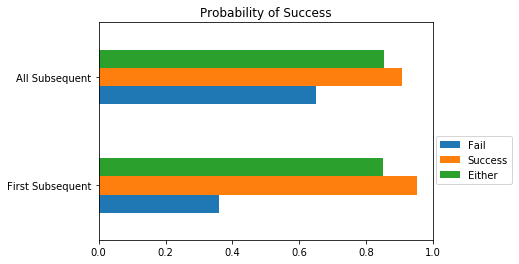

<Figure size 432x288 with 0 Axes>

In [68]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

df_plot = pd.DataFrame({'Fail': [fail_first_success_rate, fail_first_2_success_rate],
                        'Success': [success_first_success_rate, success_first_2_success_rate],
                       'Either':[multi_project_success_rate, multi_project_2_success_rate]}, 
                       index=['First Subsequent', 'All Subsequent'])

ax = df_plot.plot.barh()
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 0.5))
plt.title('Probability of Success')

plt.show()

plt.savefig(path3 + 'Monthy_duration_number_success_fail_prob_success.png')

In [32]:
# write to csv
subsets = [category_success_rate, \
           category_multi_projects_success_rate, \
           category_success_first_success_rate, \
           category_fail_first_success_rate, \
           category_multi_projects_2_success_rate, \
           category_success_first_2_success_rate, \
           category_fail_first_2_success_rate]
prob_success = {}
for k in category_success_rate.keys():
    prob_success[k] = list(str(prob_success[k]) for prob_success in subsets)
    
df8 = pd.DataFrame(prob_success.items(), columns = ['category_name', 'prob_of_success'])
count1 = 0
count2 = 0
with open(path2 + "/Prob_Of_Success_Creator.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Multiple','Multiple|Success','Multiple|Fail','Success First > Fail First','Success|Either','Success|Success','Success|Fail','Success First > Fail First'])
    for i in range(len(df8['prob_of_success'])):
        lst = list(df8['prob_of_success'])[i]
        lst1 = [ '%.4f' % float(j) for j in lst]
        if lst1[2] not in ['1.0000','1','0.0000','0'] or lst1[3] not in ['1.0000','1','0.0000','0']:
            lst2 = list(category_freq)
            lst1.insert(0, str(lst2[i]))
            diff1 = round(float(lst1[3]) - float(lst1[4]),4)
            lst1.insert(5, diff1)
            diff2 = round(float(lst1[7]) - float(lst1[8]),4)
            if diff2 > 0 and diff2 != 1:
                count1 += 1
            elif diff2 < 0 and diff2 != -1:
                count2 += 1
            lst1.insert(9, diff2)
            writer.writerow(lst1)

print("Prob of success for next project given success > given fail for the following percentage of categories: ")
print("{:.2%}".format(count1 / (count1 + count2)))
            
            

Prob of success for next project given success > given fail for the following percentage of categories: 
81.25%


In [201]:
### CALCULATION - NUMBER OF PROJECTS

category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()
project_num = dict()

#-------------------

# multiple
for k, v in category_freq.items():
    if k in category_multi_projects_freq.keys():
        project_num[k] = [category_multi_projects_freq[k]]
    else: 
        project_num[k] = [0]
        
#------------------- 

# number creators --> success|either
for k, v in category_freq.items():
    if k in category_multi_projects_2_freq.keys():
        project_num[k].append(category_multi_projects_2_freq[k])
    else:
        project_num[k].append(0)

# number creators --> success|success
for k, v in category_freq.items():
    if k in category_success_first_2_freq.keys():
        project_num[k].append(category_success_first_2_freq[k])
    else:
        project_num[k].append(0)
        
# number creators --> success|fail
for k, v in category_freq.items():
    if k in category_fail_first_2_freq.keys():
        project_num[k].append(category_fail_first_2_freq[k])
    else: 
        project_num[k].append(0)

# ------------------
        
# Write calculations to csv files

df7 = pd.DataFrame(project_num.items(), columns = ['category_name', 'number'])
with open(path2 + "/Number_Creator.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','Multiple','Success|Either','Success|Success','Success|Fail'])
    for i in range(len(df7['number'])):
        lst1 = list(df7['number'])[i]
        if lst1[0] not in [1.0,1,0.0,0]:
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [202]:
### CALCULATION - PROPORTION

project_proportion = dict()

# multiple
for k, v in category_freq.items():
    if k in category_multi_projects_freq.keys():
        project_proportion[k] = [category_multi_projects_freq[k] / len(df2)]
    else:
        project_proportion[k] = [0]
        
#------------------- 
        
# proportion creators --> success|either
for k, v in category_freq.items():
    if k in category_multi_projects_2_freq.keys():
        project_proportion[k].append(category_multi_projects_2_freq[k] / len(df2_2_2))
    else:
        project_proportion[k].append(0)
    
# proportion creators --> success|success
for k, v in category_freq.items():
    if k in category_success_first_2_freq.keys():
        project_proportion[k].append(category_success_first_2_freq[k] / len(df2_2_2_success_first))
    else:
        project_proportion[k].append(0)
        
# proportion creators --> success|fail
for k, v in category_freq.items():
    if k in category_fail_first_2_freq.keys():
        project_proportion[k].append(category_fail_first_2_freq[k] / len(df2_2_2_fail_first))
    else:
        project_proportion[k].append(0)

# ------------------
        
# Write calculations to csv files

df9 = pd.DataFrame(project_proportion.items(), columns = ['category_name', 'number'])
with open(path2 + "/Proportion_Creator.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','Multiple','Success|Either','Success|Success','Success|Fail'])
    for i in range(len(df9['number'])):
        lst1 = list(df9['number'])[i]
        if lst1[0] not in [1.0,1,0.0,0]:
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)